In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



In [21]:
# Load your data
# Replace 'gene_expression.csv' and 'patient_annotation.csv' with actual file paths
gene_expression_df = pd.read_csv('serial_norm_gene_exp_df.csv', index_col=0)  # Gene expression data
patient_annotation_df = pd.read_csv('serial_samples_annotation.csv')          # Patient annotation data

# Step 1: Calculate the average expression for each gene and select the top 500 genes

# Step 2: Transpose gene data to have patients as rows and genes as columns
genes_transposed = gene_expression_df.T
genes_transposed.index.name = 'X'  # Rename index to match patient ID for merging

# Step 3: Merge the gene expression data with patient annotations
combined_df = patient_annotation_df.merge(genes_transposed, on='X', how='inner')

# Step 4: Prepare features (gene expressions) and target (Delirium) for modeling
X = combined_df.drop(columns=['X', 'Delirium', 'Diagnosis', 'Steroids', 'Late_del', 'Subject', 'Day'])  # Feature matrix
y = combined_df['Diagnosis']  # Target variable

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [36]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [37]:
k = 200  # Choose number of features you want to keep, e.g., top 50
selector = SelectKBest(score_func=f_classif, k=k)
#X_train_selected = selector.fit_transform(X_train_scaled, y_train)
#X_test_selected = selector.transform(X_test_scaled)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [38]:
log_reg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()

# Step 9: Set up parameter grids for GridSearchCV
param_grid_log_reg = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2']
}

param_grid_knn = {
    'n_neighbors': [3, 4, 5,6, 7, 8, 9,10,11,12,13,14,15 ],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Step 10: Cross-validation and GridSearchCV for Logistic Regression
grid_log_reg = GridSearchCV(log_reg, param_grid_log_reg, cv=10, scoring='accuracy')
grid_log_reg.fit(X_train_selected, y_train)
print("Best parameters for Logistic Regression:", grid_log_reg.best_params_)
print("Best cross-validation accuracy for Logistic Regression:", grid_log_reg.best_score_)


Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l2'}
Best cross-validation accuracy for Logistic Regression: 0.9107843137254902


In [39]:
# Step 11: Cross-validation and GridSearchCV for KNN
grid_knn = GridSearchCV(knn, param_grid_knn, cv=10, scoring='accuracy')
grid_knn.fit(X_train_selected, y_train)
print("Best parameters for KNN:", grid_knn.best_params_)
print("Best cross-validation accuracy for KNN:", grid_knn.best_score_)

# Step 12: Evaluate models on test set
log_reg_best = grid_log_reg.best_estimator_
knn_best = grid_knn.best_estimator_

# Predictions and Evaluation
y_pred_log_reg = log_reg_best.predict(X_test_selected)
y_pred_knn = knn_best.predict(X_test_selected)

# Logistic Regression Performance
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))

# KNN Performance
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))

Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 6, 'weights': 'distance'}
Best cross-validation accuracy for KNN: 0.838562091503268
Logistic Regression Accuracy: 0.8717948717948718
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88        40
           1       0.89      0.84      0.86        38

    accuracy                           0.87        78
   macro avg       0.87      0.87      0.87        78
weighted avg       0.87      0.87      0.87        78

KNN Accuracy: 0.8333333333333334
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85        40
           1       0.88      0.76      0.82        38

    accuracy                           0.83        78
   macro avg       0.84      0.83      0.83        78
weighted avg       0.84      0.83      0.83        78



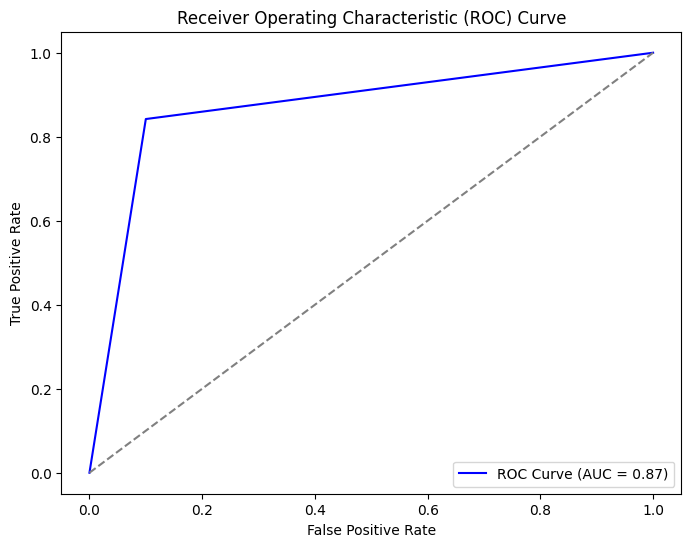

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_log_reg)

# Calculate AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_log_reg)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Dashed diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


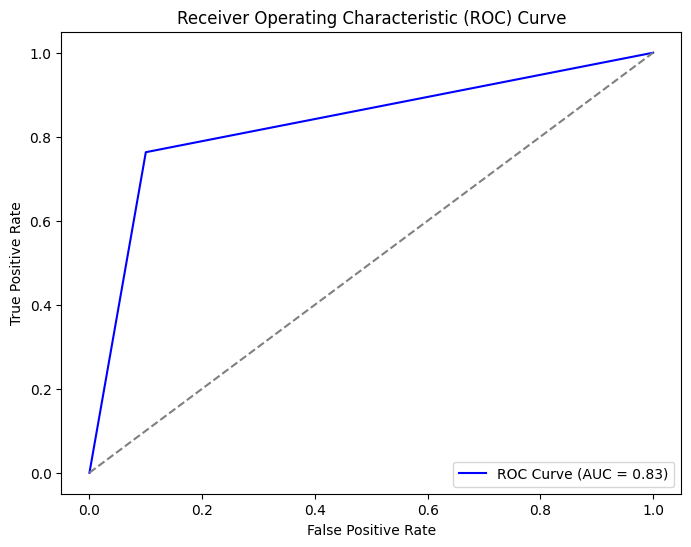

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)

# Calculate AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_knn)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Dashed diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [43]:
# Get selected feature names after SelectKBest
selected_feature_names = X.columns[selector.get_support(indices=True)]

# Assuming log_reg_best is your best Logistic Regression model from GridSearchCV
feature_importance = abs(log_reg_best.coef_[0])

# Create a DataFrame to sort features by importance
feature_importance_df = pd.DataFrame({'feature': selected_feature_names, 'importance': feature_importance})
top_10_genes = feature_importance_df.sort_values(by='importance', ascending=False).head(10)

print("Top 10 Genes Based on Importance:")
print(top_10_genes)


Top 10 Genes Based on Importance:
       feature  importance
107      U2AF1    2.769449
183   MTND2P28    2.425255
185  LINC00665    2.306733
193     CHURC1    1.856957
169     TECPR1    1.759709
181      IGLC6    1.745733
69     CLEC10A    1.733803
153        SNN    1.684249
166       CES1    1.666609
159      KRT77    1.649619


Top 10 selected gene indices: [ 5544  7376  8591  9310  9791 11175 11774 11959 12176 13049]
Top 10 selected gene scores: [14.95873094 21.41859243 14.85027325 19.6499524  23.5533974  15.5962796
 15.47207675 24.90388337 16.31993853 16.59113094]
